In [2]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [334]:
# import data
shelter_outcomes =  pd.read_csv("C:/Users/sulem/OneDrive/Desktop/machin learnign/Project3/aac_shelter_outcomes.csv")
# filter animal type for just cats
#cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
cats = shelter_outcomes
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,None,brown,True,female,0,transfer_partner
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,None,white,True,male,0,adoption_unknown
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,None,None,True,male,0,transfer_partner
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,None,None,unknown,unknown,0,euthanasia_rabies-risk


In [335]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

animal_type        object
breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int32
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



In [336]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


adoption_unknown                  27186
transfer_partner                  19660
return-to-owner_unknown           14354
adoption_foster                    5558
transfer_scrp                      3211
euthanasia_suffering               2514
euthanasia_rabies-risk             2417
transfer_snr                        626
euthanasia_aggressive               506
adoption_offsite                    367
died_in-kennel                      335
disposal_unknown                    307
euthanasia_medical                  259
euthanasia_unknown                  170
died_in-foster                      164
rto-adopt_unknown                   150
euthanasia_behavior                 142
died_unknown                         87
died_enroute                         45
died_at-vet                          33
euthanasia_underage                  28
euthanasia_at-vet                    26
euthanasia_court/investigation       18
missing_in-foster                    18
relocate_unknown                     16


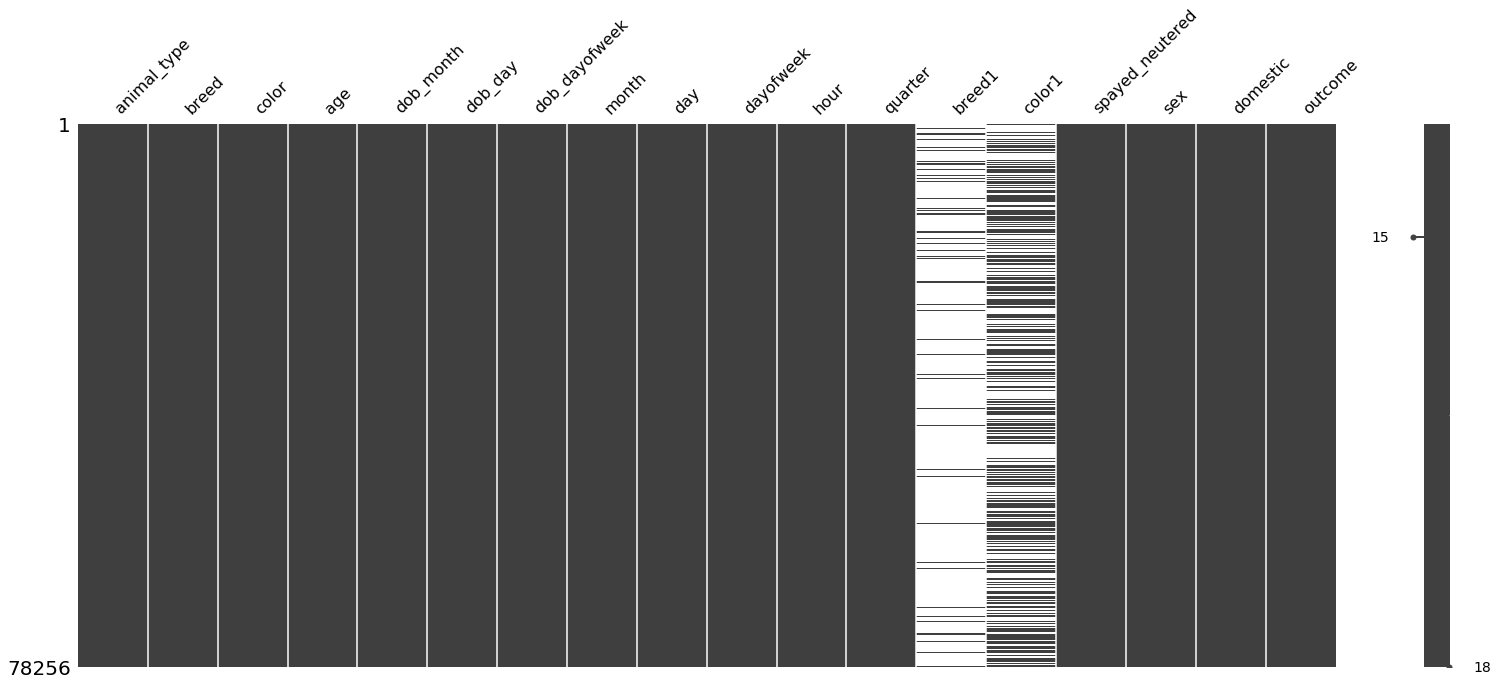

In [19]:
msno.matrix(cats )

In [337]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex','animal_type'])
cats_ohe.head()
out_t={'relocate_unknown':0,'euthanasia_court/investigation':0,'euthanasia_behavior':0,'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 0, 'euthanasia_at-vet' : 0, 'adoption_foster' : 1, 'died_in-foster' : 0, 'transfer_scrp' : 0, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 1, 'missing_in-foster' : 0, 'adoption_offsite' : 1, 'adoption_unknown' :1,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}
#output is converted from string to catogries 0 to 5 represent each output
# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
X_test.drop(columns=['outcome'], inplace=True)
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
1   366         11        6              1     11    7          3    11   
2   429          3       31              6      6    3          1    14   
3  3300          6        2              3      6   15          6    15   
4   181          1        7              1      7    7          0    14   

   quarter  domestic        ...         spayed_neutered_True  \
0        3         1        ...                            0   
1        4         0        ...                            1   
2        2         0        ...                            1   
3        2         0        ...                            1   
4        3         0        ...                            0   

   spayed_neutered_unknown  sex_female  sex_male  sex_unknown  \
0                        0           0         1            0   
1                        0        

In [111]:
y_train

array([0, 1, 5, ..., 3, 3, 0])

In [38]:
from sklearn import metrics as mt
import keras
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
keras.__version__

'2.2.4'

In [338]:
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_test_ar=X_test.values
y_test_ar=np.asarray(y_test)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)

print(x_train_ar.shape)
print(y_target_ar.shape)
unique, counts = np.unique(y_target_ar, return_counts=True)
np.asarray((unique, counts))

(62604, 473)
(62604,)


array([[    0,     1],
       [35934, 26670]], dtype=int64)

In [346]:
from sklearn.preprocessing import OneHotEncoder


In [339]:
inputs = Input(shape=(x_train_ar.shape[1],))
x = Dense(units=100, activation='relu')(inputs)
x = Dense(units=100, activation='relu')(x)
predictions = Dense(1,activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

In [342]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 473)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 100)               47400     
_________________________________________________________________
dense_100 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 101       
Total params: 57,601
Trainable params: 57,601
Non-trainable params: 0
_________________________________________________________________


In [343]:
#%%time

model.fit(x_train_ar, y_target_ar, epochs=10, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat_proba = model.predict(x_test_ar)
yhat = np.round(yhat_proba)
#print(mt.confusion_matrix(y_test_ar,yhat),mt.accuracy_score(y_test_ar,yhat))

In [344]:
test_scores = model.evaluate(x_test_ar, y_test_ar, verbose=0)
test_scores

[0.441857847630018, 0.5550728341426016]

In [345]:
print(mt.confusion_matrix(y_test_ar,yhat),mt.accuracy_score(y_test_ar,yhat))

[[8685  376]
 [6588    3]] 0.5550728341426016


(15652, 7)

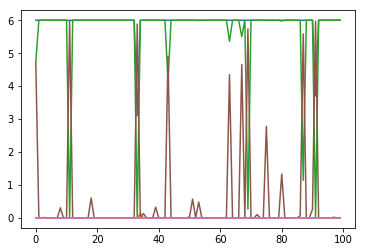

In [332]:
from matplotlib import pyplot as plt
plt.plot(yhat_proba[:100]*6)

np.where(yhat_proba[10] == yhat_proba[10].max())
yhat_proba.shape